In [1]:
include("../LiPoSID.jl")

using LinearAlgebra

using DynamicPolynomials

using SymPy

using Plots

using Dates

using HDF5

data_dir = "../DATA/"

γ_list = [ "0.079477",  "0.25133", "0.79477", "2.5133", "7.9477", "25.133",  "79.477", "251.33"]

γ_list_disp = [ "0.0795",  "0.2513", "0.7947", "2.5133", "7.9477", "25.133",  "79.477", "251.33"];

b⁰ = [0, 0, 1, 1]
b¹ = [0, 0, -1, 1]
bˣ = [1, 0, 0, 1]
bʸ = [1, 1, 0, 1]


function ⊗(A::AbstractMatrix, B::AbstractMatrix)
    return kron(A,B)
end

function LME_operator_symbolic(H, J)
    
    Id = I(2)   
    U = -im*(Id ⊗ H - transpose(H) ⊗ Id)
    D = sum( 2*transpose(j')⊗j-Id⊗(j'*j) - transpose(j)*transpose(j')⊗Id for j in J )/2 
    
    Lᴸᴹᴱ = U + D
    
    return Lᴸᴹᴱ
end

function SumCoeffs2(poly, s)
    p = SymPy.expand(poly)
    rest_poly = SymPy.subs(p, s => 0)
    degrees = range(1,convert(Int32,SymPy.degree(p, s)))
    
    obj = sum(p.coeff(s^i)^2 for i in degrees) #+ rest_poly^2  
    
    return obj
end 

function sympy_to_dynamicpoly(sympy_expr::Sym) #
    # Extract variables from the SymPy expression
    vars = free_symbols(sympy_expr)

    # Convert SymPy variables to string and then to Symbol
    var_symbols = [Symbol(string(v)) for v in vars]

    # Create DynamicPolynomials variables using @polyvar macro
    @eval begin
        @polyvar $(var_symbols...)
    end

    # Map SymPy variables to DynamicPolynomials variables
    var_map = Dict(vars[i] => eval(var_symbols[i]) for i in 1:length(vars))

    # Substitute using subs and convert to DynamicPolynomial
    dynamic_poly_expr = SymPy.subs(sympy_expr, var_map)
    dynamic_poly = eval(Meta.parse(string(dynamic_poly_expr)))
    return dynamic_poly
end


function TF_objective(Aˢʸᵐᵇ, Aˢⁱᵈ, b)

    @syms s

    Gˢʸᵐᵇ = inv(I(4)*s - Aˢʸᵐᵇ)*b

    Gˢⁱᵈ = inv(I(4)*s - Aˢⁱᵈ)*b

    #ΔG = SymPy.together.(Gˢʸᵐᵇ[1:3] - Gˢⁱᵈ[1:3])
    ΔG = SymPy.together.(Gˢʸᵐᵇ - Gˢⁱᵈ)

    polys = SymPy.numerator.(ΔG)

    obj = sum(SumCoeffs2.(polys.^2, s))

    #objective = sympy_to_dynamicpoly(obj)

    return obj

end

function read_Ac(models_file_name, γ)
    h5open(models_file_name, "r") do file
        Ac = read(file["gamma_"*string(γ)]["Ac"])
        return Ac
    end
end

function dmd_Ac(γ)

    data_dir = "../DATA/"
    
    ρᵉ, tᵉ = LiPoSID.get_rho_series(data_dir*"State_B1_2CUT_data.h5", γ)
    ρᵍ, tᵍ = LiPoSID.get_rho_series(data_dir*"State_B2_2CUT_data.h5", γ)
    ρˣ, tˣ = LiPoSID.get_rho_series(data_dir*"State_B3_2CUT_data.h5", γ)
    ρʸ, tʸ = LiPoSID.get_rho_series(data_dir*"State_B4_2CUT_data.h5", γ)

    Δt = tᵉ[2]-tᵉ[1]

    lᵉ = length(ρᵉ); lᵍ = length(ρᵍ); lˣ = length(ρˣ); lʸ = length(ρʸ)
    lᵐᵃˣ = min(lᵉ, lᵍ,  lˣ, lʸ)  #choose time limit by shortest series

    Aᴰᴹᴰ⁻ˢᴮ = LiPoSID.direct_DMD_01XY_b4_A([ρᵉ[1:lᵐᵃˣ], ρᵍ[1:lᵐᵃˣ], ρˣ[1:lᵐᵃˣ], ρʸ[1:lᵐᵃˣ]])
    Acᴰᴹᴰ⁻ˢᴮ = log(Aᴰᴹᴰ⁻ˢᴮ)/Δt

    return Acᴰᴹᴰ⁻ˢᴮ

end

function sb_TF_objective(γ, Acˢʸᵐᵇ)
    models_file_name="../MODELS/DMD_b4_LTI_trn4_2023-Nov-29_at_17-38.h5"
    Acᴰᴹᴰ = read_Ac(models_file_name, γ)
    obj =  TF_objective(Acˢʸᵐᵇ, Acᴰᴹᴰ, bˣ) + TF_objective(Acˢʸᵐᵇ, Acᴰᴹᴰ, bʸ) + TF_objective(Acˢʸᵐᵇ, Acᴰᴹᴰ, b¹)
    objective = sympy_to_dynamicpoly(obj)
    return objective
end

#Functions for plotting heatmaps

function plot_TF_objective(γ, Aᴸᴹᴱ)

    objective = sb_TF_objective(γ, Aᴸᴹᴱ)

    function f(γ_val, ω_val)
        return objective(variables(objective)[1] => γ_val, variables(objective)[2] => ω_val)
    end
    
    function f(γ_val)
        return objective(variables(objective)[1] => γ_val)
    end

    γᶠ = parse(Float64, γ)

    w = range(-30, 30, length=1000)
    g = range(-30*γᶠ, 30*γᶠ, length=1000)
    #g = range(-10, 10, length=500)
    z = @. f(g', w)

    heatmap(g, w, log.(z))
    title!("γ = "*string(γ))

    #contour(g, w, log.(z))

end

function contour_obj(objective)

    function f(γ_val, ω_val)
        return objective(variables(objective) => (γ_val, ω_val))
    end
    
    w = range(-20, 10, length=1000)
    g = range(-3, 3, length=1000)

    z = @. f(g', w)

    contour(g, w, log.(z))
end

function coef_range(obj)
    maximum(abs.(coefficients(obj)))/minimum(abs.(coefficients(obj)))
end

function scaling_poly(p::Polynomial)

    X = transpose(hcat([exponents(t) for t in terms(p)]...))

    # Get the scaling via linear regression
    scaling = X \ log.(abs.(coefficients(p)))

    exp.(abs.(scaling)) # 
end


scaling_poly (generic function with 1 method)

In [2]:
models_file_name="../MODELS/DMD_b4_LTI_trn4_2023-Nov-29_at_17-38.h5"
Acᴰᴹᴰ = read_Ac(models_file_name, γ_list[4])

4×4 Matrix{Float64}:
 -1.09539e-6   -25.1327        0.000678345   0.000288167
 25.4256        -2.5375       -0.000944828  -0.00272287
 -0.218801      -0.0565769    -2.5393        2.46159
  4.41832e-13   -1.77842e-12   4.25337e-13   4.75864e-13

In [3]:
ω = SymPy.symbols("ω", real=true)
γ = SymPy.symbols("γ", real=true)

Hᴸᴹᴱ = [ ω        0
         0        0   ]


Jᴸᴹᴱ = [ 0     γ
         0     0. + 0im  ]

Lᴸᴹᴱ = LME_operator_symbolic(Hᴸᴹᴱ, [Jᴸᴹᴱ])

M =   [ 0  0    1  1
        1  -im  0  0 
        1  im   0  0
        0  0   -1  1 ]/2

Aˢ = [ -γ/2  ω      0      0  
       -ω   -γ/2    0      0
        0    0     -γ      γ
        0    0      0      0    ] #==#

#Aᴸᴹᴱ = real.(inv(M) * Lᴸᴹᴱ * M)

4×4 Matrix{Sym{PyCall.PyObject}}:
 -0.5*γ^2     1.0⋅ω         0        0
   -1.0⋅ω  -0.5*γ^2         0        0
        0         0  -1.0*γ^2  1.0*γ^2
        0         0         0        0

In [5]:
γ_tst = γ_list[4]

obj = sb_TF_objective(γ_tst, Aˢ)

2.5354689335439406e65γ⁸ + 4.056750293670305e66γ⁶ω² + 2.434050176202182e67γ⁴ω⁴ + 6.490800469872476e67γ²ω⁶ + 6.490800469872463e67ω⁸ + 6.23224743682572e67γ⁷ + 1.1917723583062528e68γ⁶ω + 7.478696924190864e68γ⁵ω² + 1.4301268299675044e69γ⁴ω³ + 2.9914787696763426e69γ³ω⁴ + 5.7205073198700175e69γ²ω⁵ + 3.988638359568449e69γω⁶ + 7.62734309316002e69ω⁷ + 6.018518600025408e69γ⁶ + 2.2093237743052402e70γ⁵ω + 6.952669686971468e70γ⁴ω² + 1.767459019444193e71γ³ω³ + 2.67324682156498e71γ²ω⁴ + 3.534918038888384e71γω⁵ + 3.4205676911218365e71ω⁶ + 2.2635730847176474e71γ⁵ + 1.4003084185173939e72γ⁴ω + 3.5766624831893396e72γ³ω² + 7.37667497286988e72γ²ω³ + 1.0684932997209137e73γω⁴ + 7.101765195201223e72ω⁵ + 7.622691653634639e72γ⁴ + 3.2349204402642356e73γ³ω + 8.82756299607625e73γ²ω² + 1.1823615950932196e74γω³ + 6.380311743561198e73ω⁴ + 4.2293531209497156e73γ³ + 1.317351175628493e74γ²ω + 2.459743617661753e74γω² + 1.6456710281451867e74ω³ + 1.2347339008094356e74γ² + 2.5250639060258714e74γω + 2.411631556451688e74ω² + 1.

In [6]:
coef_range(obj)

9.958962117893019e8

In [7]:
pd = obj / maximum(abs.(coefficients(obj)))

1.004120698685383e-9γ⁸ + 1.6065931178966128e-8γ⁶ω² + 9.639558707379674e-8γ⁴ω⁴ + 2.5705489886345757e-7γ²ω⁶ + 2.570548988634571e-7ω⁸ + 2.4681543393626357e-7γ⁷ + 4.719771073762448e-7γ⁶ω + 2.9617852072351626e-6γ⁵ω² + 5.663725288514942e-6γ⁴ω³ + 1.1847140828940637e-5γ³ω⁴ + 2.2654901154059767e-5γ²ω⁵ + 1.5796187771920817e-5γω⁶ + 3.0206534872079673e-5ω⁷ + 2.38351139773638e-5γ⁶ + 8.749575680175295e-5γ⁵ω + 0.00027534628610307465γ⁴ω² + 0.000699966054414024γ³ω³ + 0.0010586848179111354γ²ω⁴ + 0.001399932108828047γω⁵ + 0.001354645988546632ω⁶ + 0.0008964418996746196γ⁵ + 0.0055456355586710705γ⁴ω + 0.014164641436020328γ³ω² + 0.029213814966290597γ²ω³ + 0.04231549534928745γω⁴ + 0.02812509092642529ω⁵ + 0.030188113795629766γ⁴ + 0.1281124185627281γ³ω + 0.3495976072134233γ²ω² + 0.46825016676671205γω³ + 0.25267921846789987ω⁴ + 0.16749489432155315γ³ + 0.5217100337479521γ²ω + 0.9741312335865099γω² + 0.6517344072828886ω³ + 0.4889911490409561γ² + γω + 0.9550774341578105ω² + 0.623611344634702γ + 0.6249594943100564ω 

In [8]:
scale = scaling_poly(pd)
p_scaled = DynamicPolynomials.subs(pd, variables(pd) => scale .* variables(pd))

0.002561940706004902γ⁸ + 0.010852119281651503γ⁶ω² + 0.017238176018353403γ⁴ω⁴ + 0.01216985896087826γ²ω⁶ + 0.0032218925084500304ω⁸ + 0.09961106280756568γ⁷ + 0.09800967417707078γ⁶ω + 0.31645671955621174γ⁵ω² + 0.3113692304916687γ⁴ω³ + 0.33511958922924157γ³ω⁴ + 0.32973206815555817γ²ω⁵ + 0.11829436396301776γω⁶ + 0.1163926148584236ω⁷ + 1.5216143625452692γ⁶ + 2.874002283193303γ⁵ω + 4.653632575237025γ⁴ω² + 6.08699013209965γ³ω³ + 4.737018216102862γ²ω⁴ + 3.222983597207742γω⁵ + 1.6046846077659946ω⁶ + 9.05235587107417γ⁵ + 28.81399976362666γ⁴ω + 37.86784220380398γ³ω² + 40.18518746249526γ²ω³ + 29.94952263052262γω⁴ + 10.242292198031345ω⁵ + 48.22003882116273γ⁴ + 105.29204441211587γ³ω + 147.83781345752809γ²ω² + 101.88441843970453γω³ + 28.288642418025827ω⁴ + 42.31996073699869γ³ + 67.82434732573746γ²ω + 65.16083684360237γω² + 22.431204010978618ω³ + 19.543249967893853γ² + 20.564044717002645γω + 10.10554812282909ω² + 3.9424110328005724γ + 2.0328836149224565ω + 0.40325675930411325

In [9]:
coef_range(p_scaled)

57705.400094160184

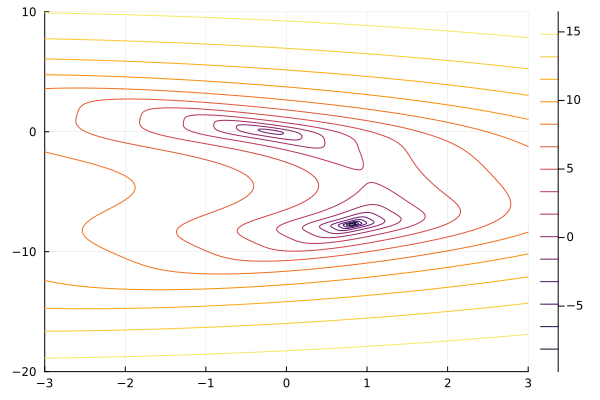

In [10]:
contour_obj(p_scaled)

In [11]:
using TSSOS

opt,sol,data = tssos_first(p_scaled, variables(p_scaled), solution=true)

*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...


Starting to compute the block structure...


-----------------------------------------------------------------------------
The sizes of PSD blocks:
[15]
[1]
-----------------------------------------------------------------------------
Obtained the block structure. The maximal size of blocks is 15.


Assembling the SDP...
There are 45 affine constraints.


Solving the SDP...


Problem
  Name                   :                 
  Objective sense        : maximize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 45              
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 1               
  Matrix variables       : 2 (scalarized: 126)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - dual attempts          : 0        

optimum = 6.002100029448926e-5


Global optimality certified with relative optimality gap 0.000002%!


(6.002100029448926e-5, [0.8193046078902947, -7.714523484814989], TSSOS.upop_data(2, 0, PolyVar{true}[γ, ω], 0.002561940706004902γ⁸ + 0.010852119281651503γ⁶ω² + 0.017238176018353403γ⁴ω⁴ + 0.01216985896087826γ²ω⁶ + 0.0032218925084500304ω⁸ + 0.09961106280756568γ⁷ + 0.09800967417707078γ⁶ω + 0.31645671955621174γ⁵ω² + 0.3113692304916687γ⁴ω³ + 0.33511958922924157γ³ω⁴ + 0.32973206815555817γ²ω⁵ + 0.11829436396301776γω⁶ + 0.1163926148584236ω⁷ + 1.5216143625452692γ⁶ + 2.874002283193303γ⁵ω + 4.653632575237025γ⁴ω² + 6.08699013209965γ³ω³ + 4.737018216102862γ²ω⁴ + 3.222983597207742γω⁵ + 1.6046846077659946ω⁶ + 9.05235587107417γ⁵ + 28.81399976362666γ⁴ω + 37.86784220380398γ³ω² + 40.18518746249526γ²ω³ + 29.94952263052262γω⁴ + 10.242292198031345ω⁵ + 48.22003882116273γ⁴ + 105.29204441211587γ³ω + 147.83781345752809γ²ω² + 101.88441843970453γω³ + 28.288642418025827ω⁴ + 42.31996073699869γ³ + 67.82434732573746γ²ω + 65.16083684360237γω² + 22.431204010978618ω³ + 19.543249967893853γ² + 20.564044717002645γω + 10.10

In [12]:
γᵗˢˢᵒˢ, ωᵗˢˢᵒˢ = sol

2-element Vector{Float64}:
  0.8193046078902947
 -7.714523484814989

In [13]:
variables(p_scaled)[2]

ω

In [14]:
using Optim

initial_point = [1, -10.0]
result = optimize(p_scaled, initial_point, BFGS()) 

 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Final objective value:     5.442022e-05

 * Found with
    Algorithm:     BFGS

 * Convergence measures
    |x - x'|               = 2.93e-14 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.79e-15 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.08e-11 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.66e-07 ≰ 0.0e+00
    |g(x)|                 = 3.23e-06 ≰ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    168
    f(x) calls:    1157
    ∇f(x) calls:   1157


In [15]:
γᶠ, ωᶠ = Optim.minimizer(result)

2-element Vector{Float64}:
  0.8106156614013815
 -7.728670772490945

In [16]:
p_scaled(variables(p_scaled) => (γᶠ, ωᶠ))

5.4420211043515465e-5

In [17]:
p_scaled(variables(p_scaled) => (γᵗˢˢᵒˢ, ωᵗˢˢᵒˢ))

6.00049871038455e-5

In [18]:
using JLD2
save_object("objective2.jld2", p_scaled)